# hw4 - NN pyTorch

Во всем задании вы должны работать со входом из строк размером (длиной) 1024

## Часть 1 Фурье

### Подготовка данных

Сгенерите данные (сигнал) любым пакетом для численного преобразования Фурье, [например](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#numpy.fft.fft)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
from scipy.signal import periodogram
from sklearn.model_selection import train_test_split

from torch import nn
from torch.optim import Adam
import torch
from tqdm import tqdm

In [23]:
class MyNet(nn.Module):
    def __init__(self, n_in=1024, n_features=2048, n_out=1024, activation=nn.ReLU):
        super(MyNet, self).__init__()
        self.n_out = n_out
        self.n_in = n_in
        self.model = nn.Sequential(
            nn.Linear(self.n_in, n_features),
            activation(),
            nn.Linear(n_features, n_features),
            activation(),
            nn.Linear(n_features, n_features),
            activation(),
            nn.Linear(n_features, self.n_in),
            activation(),
            nn.Linear(self.n_in, n_out)
        )
        
    def forward(self, X):
        return self.model(X)
        

In [24]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [25]:
def plot_sample(data, predict, xf):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.title("Original")
    plt.plot(xf, data)
    plt.grid()

    plt.subplot(122)
    plt.title("Predict")
    plt.plot(xf, predict)
    plt.grid()

In [26]:
def batch_train(
    x: torch.Tensor,
    y: torch.Tensor,
    optimizer: torch.optim.Optimizer,
    model: nn.Module,
    loss_fn, #:  torch.nn.Loss,
):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(y, pred)
    loss.backward()
    optimizer.step()
    return loss

In [27]:
def train_loop(
    x_train: torch.Tensor,
    y_train: torch.Tensor,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    batch_size: int,
    model: nn.Module,
    loss_fn, #:  torch.nn.Loss,
    log_iteration=10,
):
    data_size = x_train.size()[0]
    
    history_loss = []
    gen_samples = []
    
    iter = 0
    for epoch in tqdm(range(num_epochs)):
        permutation = torch.randperm(data_size)
        
        for i in range(0, data_size, batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = x_train[indices], y_train[indices]
            loss = batch_train(
                batch_x, batch_y, 
                optimizer, model, loss_fn
            )
            if iter % log_iteration == 0:
                history_loss += [loss.item()]
                sample = batch_y[0]
                with torch.no_grad():
                    gen_sample = model(batch_x[0]).to("cpu").detach().numpy()
                gen_samples += [(sample.to("cpu").numpy(), gen_sample)]
                
            iter += 1
    return history_loss, gen_samples
            

In [28]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_SIZE = 50000
BATCH_SIZE = 1024
EPOCHS = 100
TEST_SIZE = 0.2

In [29]:
N = 1024
dt = 1 / (1024 / 4)

x = np.linspace(0, N * dt, N)
xf = np.linspace(-1/dt, 1/dt, N)

freq_max = 1 / 2 / dt
freqs = np.linspace(0, freq_max, DATA_SIZE)

In [30]:
def generate_data(
    spec_func, 
    DEVICE="cpu", 
    TEST_SIZE=0.2
):
    signals = np.array([np.sin(np.pi * freq * x) for freq in freqs])
    specs = spec_func(signals)

    x_train_array, x_test_array, y_train_array, y_test_array = train_test_split(
        signals, specs, test_size=TEST_SIZE, random_state=42, shuffle=True
    )

    x_train = torch.tensor(x_train_array, device=DEVICE, dtype=torch.float)
    y_train = torch.tensor(y_train_array, device=DEVICE, dtype=torch.float)
    x_test = torch.tensor(x_test_array, device=DEVICE, dtype=torch.float)
    y_test = torch.tensor(y_test_array, device=DEVICE, dtype=torch.float)
    return (x_train, y_train, x_test, y_test)

In [31]:
func = lambda x: np.array(abs(fft.fftshift(fft.fft(x, axis=1), axes=1)))
x_train, y_train, x_test, y_test = generate_data(func, DEVICE, TEST_SIZE)

In [32]:
loss_fn = torch.nn.MSELoss()
model = MyNet(
    n_in=1024,
    n_features=2048,
    n_out=1024
).apply(init_weights).to(DEVICE)
optimizer = Adam(model.parameters(), lr=0.001)

history_loss, gen_samples = train_loop(
    x_train,
    y_train,
    optimizer,
    EPOCHS,
    BATCH_SIZE,
    model,
    loss_fn,
    log_iteration=BATCH_SIZE//5
)

100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


20 0.8661806583404541


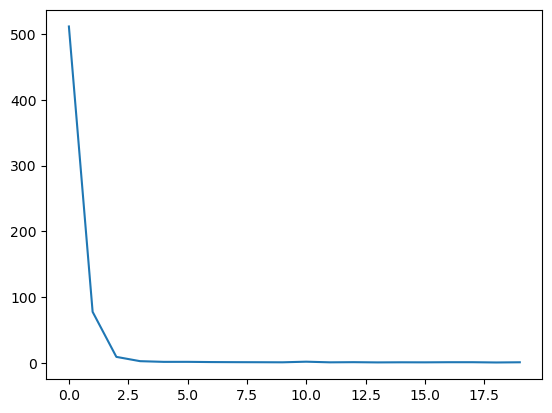

In [33]:
print(len(history_loss), history_loss[-1])
plt.plot(history_loss)

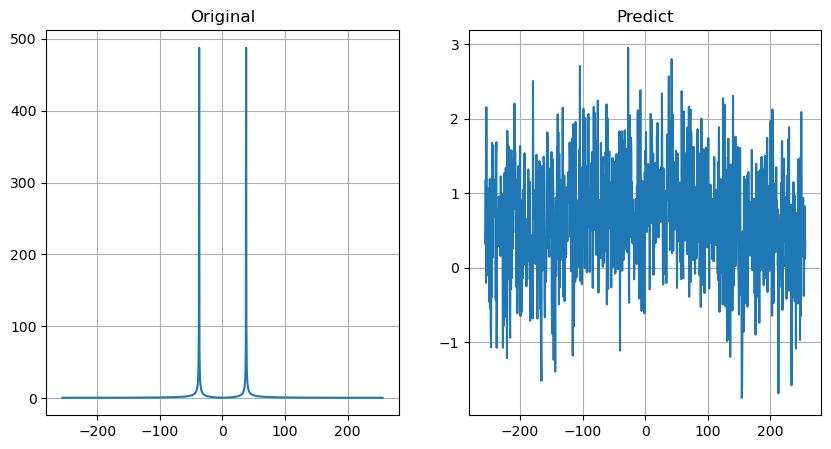

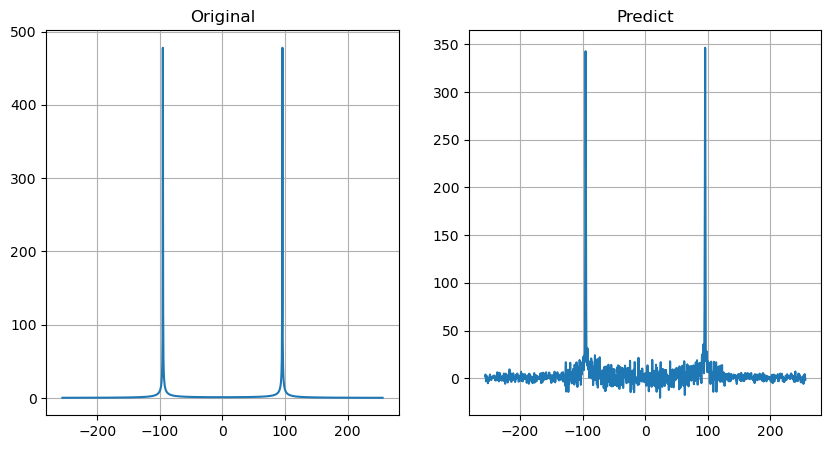

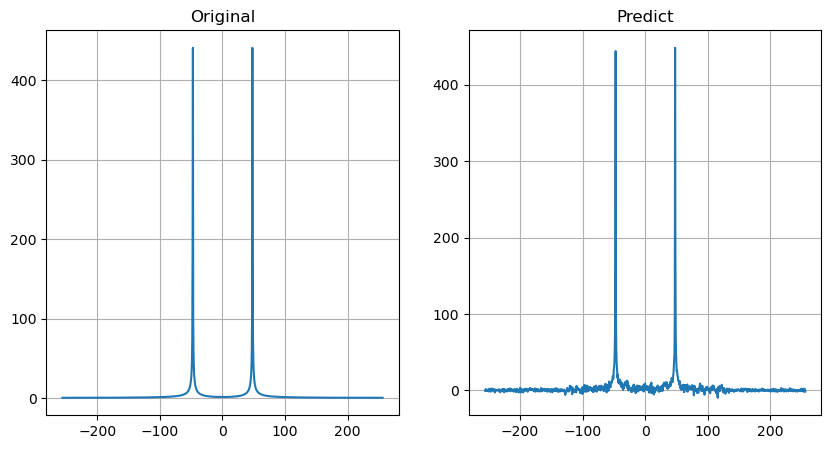

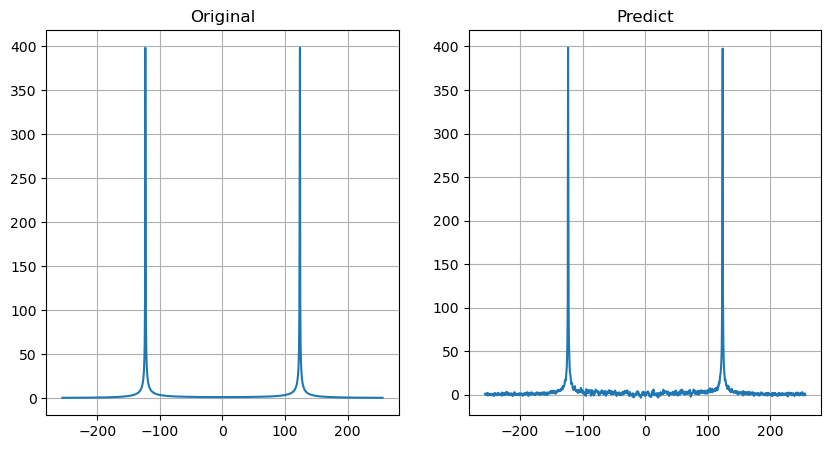

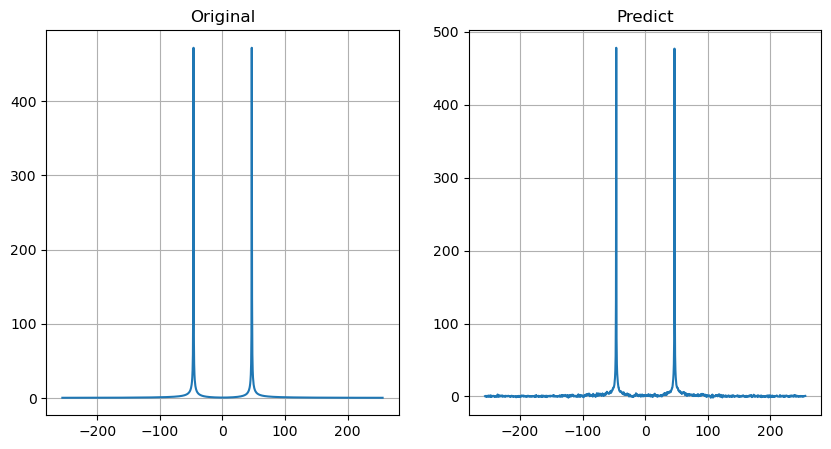

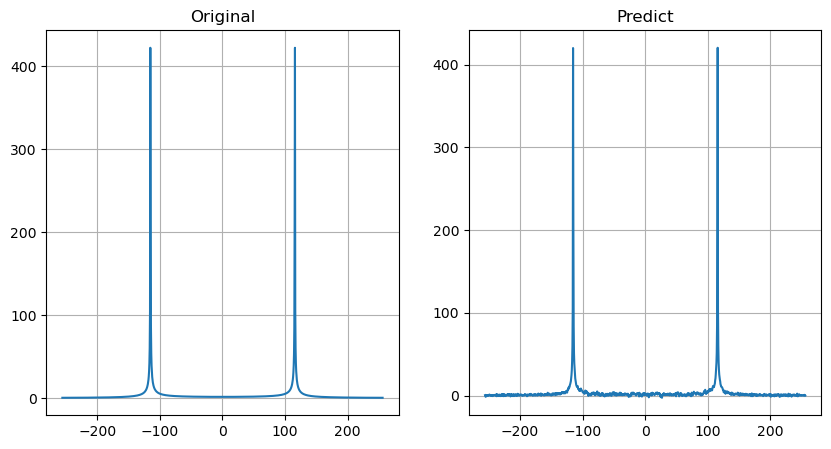

In [35]:
for original, predict in gen_samples[:len(gen_samples)//3]:
    plot_sample(original, predict, xf)
    plt.show()

tensor(0.8017)


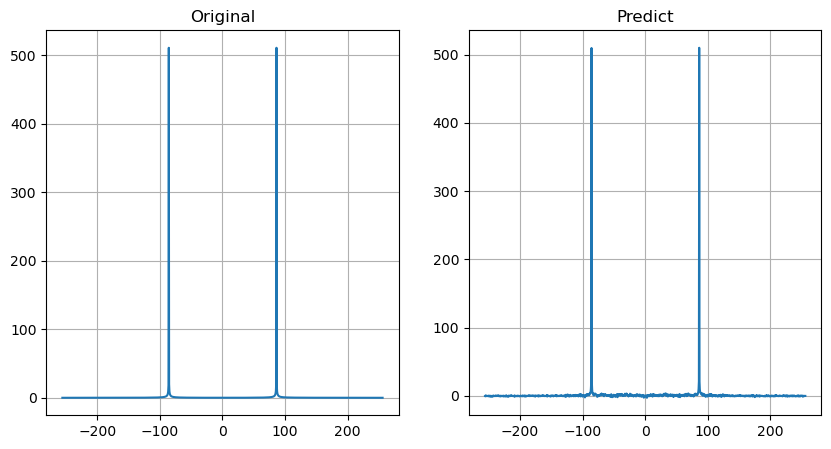

tensor(0.8109)


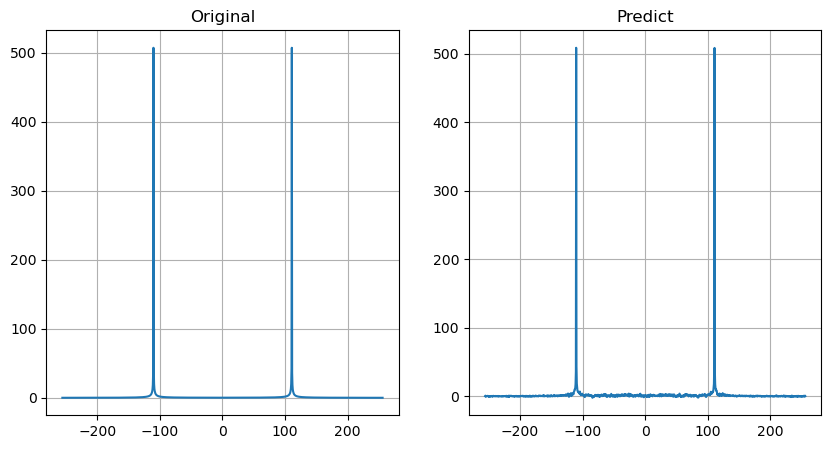

tensor(0.6951)


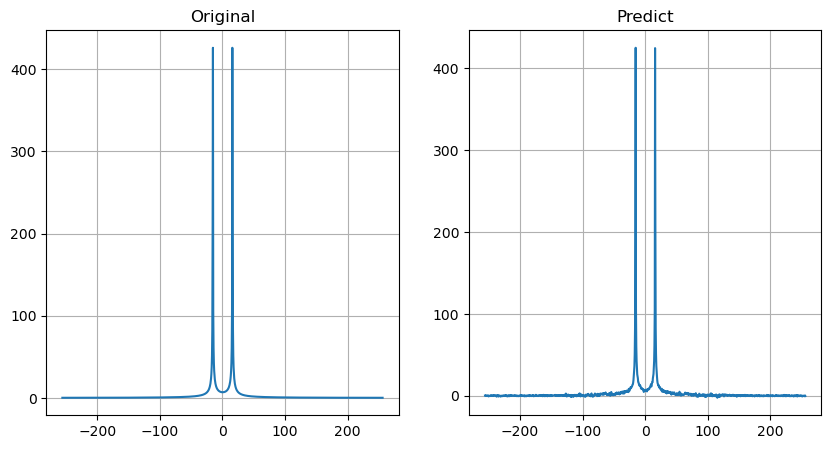

tensor(1.2944)


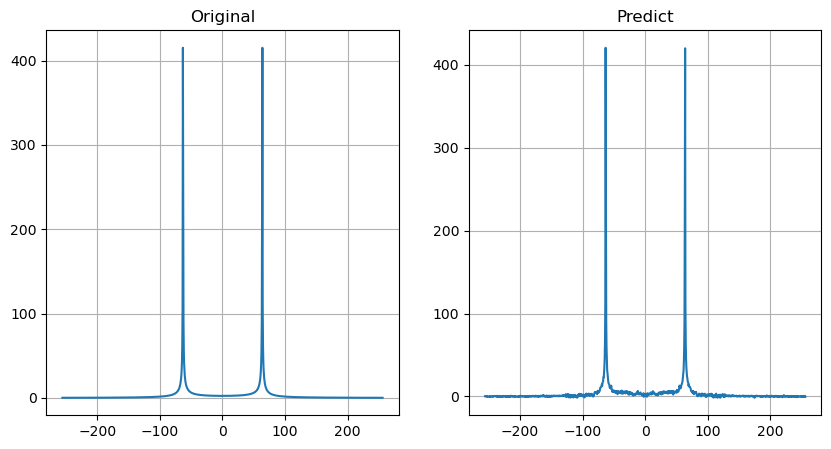

In [36]:
idxs = [0, 10, 20, 50]
for idx in idxs:
    with torch.no_grad():
        gen = model(x_test[idx]).to("cpu")
    plot_sample(y_test[idx].to("cpu"), gen, xf)
    print(loss_fn(y_test[idx].to("cpu"), gen))
    plt.show()

## Часть 2 Power spectral density (dB)

Используя пакетное решение, [например](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html), подготовьте обучающую выборку.

In [37]:
func = lambda x: periodogram(x)[1]
x_train, y_train, x_test, y_test = generate_data(func, DEVICE, TEST_SIZE)

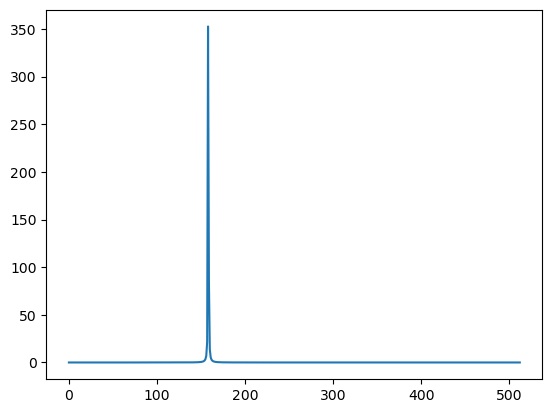

In [38]:
plt.plot(y_train[1].to("cpu"))

In [39]:
loss_fn = torch.nn.MSELoss()
model2 = MyNet(
    n_in=1024,
    n_features=2048,
    n_out=513
).apply(init_weights).to(DEVICE)
optimizer = Adam(model2.parameters(), lr=0.001)

history_loss, gen_samples = train_loop(
    x_train,
    y_train,
    optimizer,
    EPOCHS,
    BATCH_SIZE,
    model2,
    loss_fn,
    log_iteration=BATCH_SIZE//5
)

100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


20 0.3472890853881836


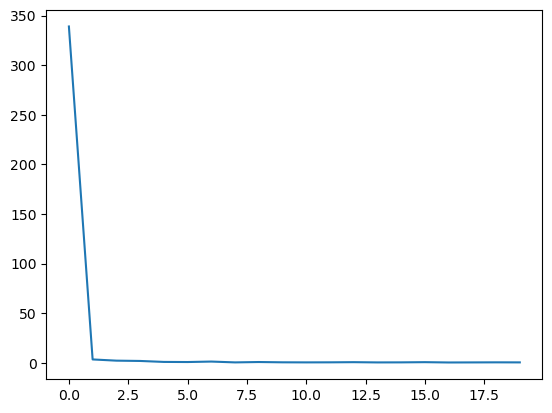

In [40]:
print(len(history_loss), history_loss[-1])
plt.plot(history_loss)

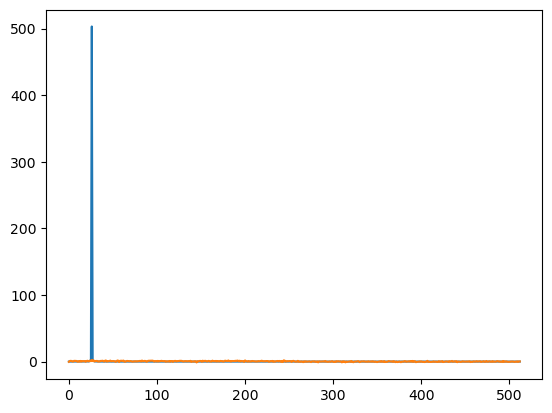

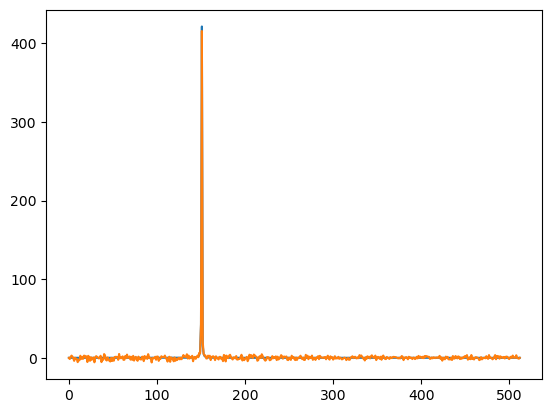

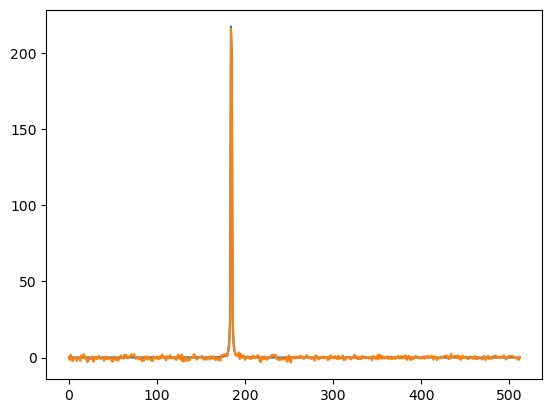

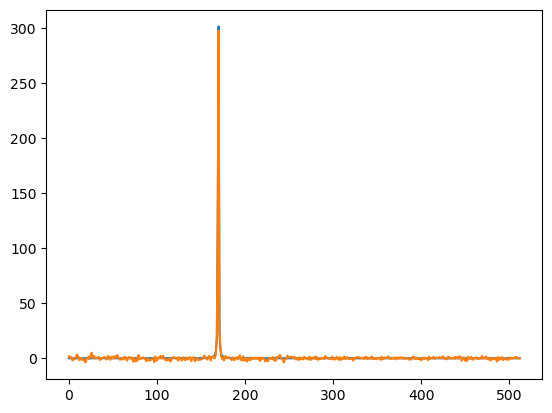

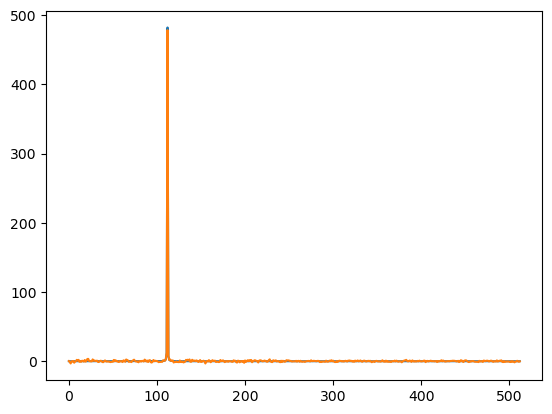

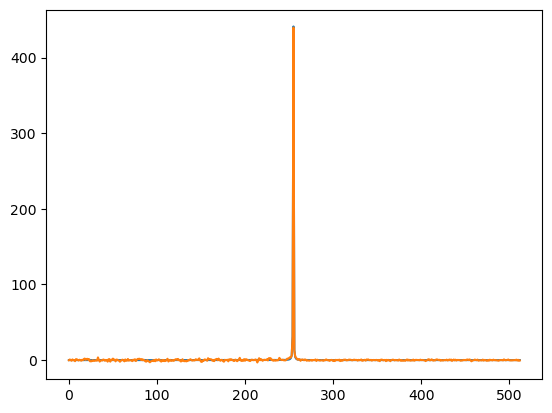

In [41]:
for original, predict in gen_samples[:len(gen_samples)//3]:
    plt.plot(original)
    plt.plot(predict)
    plt.show()

tensor(0.3974)


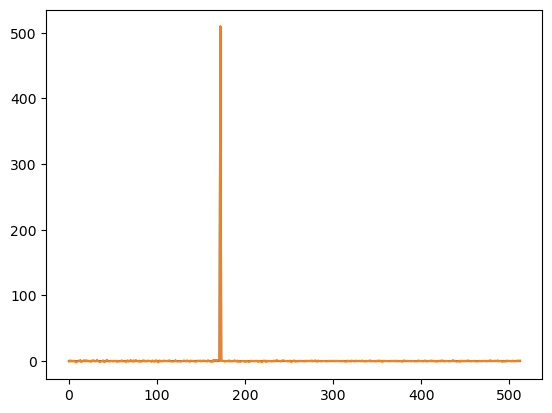

tensor(0.3572)


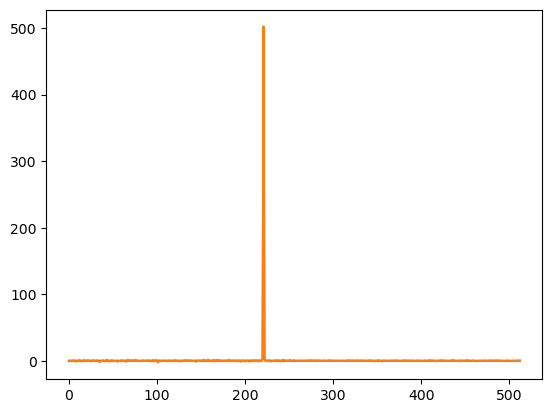

tensor(0.2770)


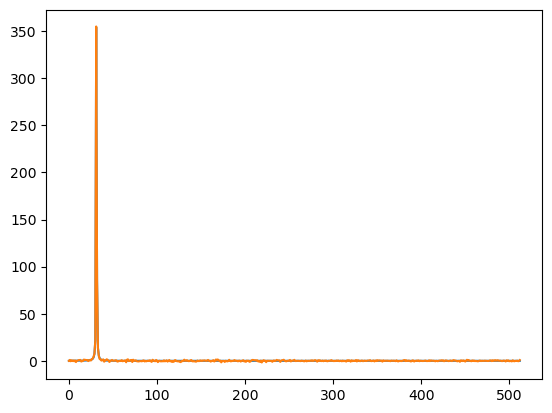

tensor(0.2716)


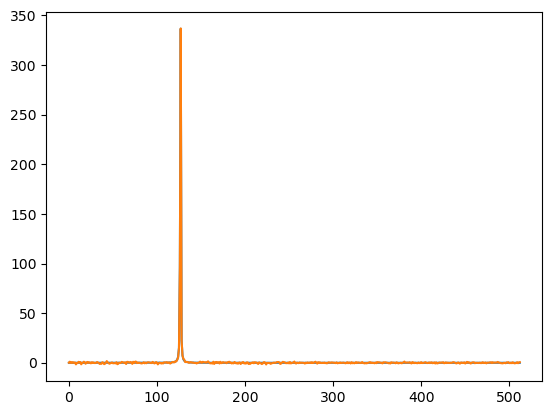

In [44]:
idxs = [0, 10, 20, 50]
for idx in idxs:
    with torch.no_grad():
        gen = model2(x_test[idx]).to("cpu")
    plt.plot(y_test[idx].to("cpu"))
    plt.plot(gen)
    print(loss_fn(y_test[idx].to("cpu"), gen))
    plt.show()